# Jorual DAO: A New Framework for DeSci in Web 3.0

In [1]:
from math import floor
import pandas as pd
from random import randint
import matplotlib.pyplot as plt

## type

In [2]:
class IUser():
  address: int
  token: int
  def __init__(self, address:str, token:int) -> None:
    self.address = address
    self.token = token

class IPublicater(IUser):
  def __init__(self, address:str) -> None:
    super().__init__(address, 0)

class IReview(IUser):
  rating: int
  def __init__(self, address:str, rating:int) -> None:
    self.rating = rating
    super().__init__(address, 0)

class IAuthor(IUser):
  sequence: int
  weight: int
  def __init__(self, address:str, sequence:int) -> None:
    self.sequence = sequence
    super().__init__(address, 0)

class ICitedBy(IUser):
  articleID: int
  def __init__(self, address:str, articleID:int) -> None:
    self.articleID = articleID
    super().__init__(address, 0)



## dao class

In [3]:
class ArticleDAO:
  _distribution:list[IUser]
  _articleID = None
  _publicater = IPublicater
  _authors:list[IAuthor]
  _reviewers:list[IReview]
  _downloads:list[IUser]
  _cites:list[ICitedBy]
  _holder =pd.DataFrame()
  _log = pd.DataFrame()
  _finance = pd.DataFrame()
  DOWNLOAD_FEE = 1
  PUBLICATER_TOKEN = 500
  AUTHOR_TOKEN = 1000
  REVIEW_TOKEN = 1000
  DOWNLOAD_TOKEN = 18
  DOWNLOAD_AUTHOR_TOKEN = 24
  CITE_TOKEN = 36
  CITE_ATHOR_TOKEN = 6
  def __init__(self, articleID:int, publicater:str):
    self._articleID = articleID
    self._publicater = IPublicater(publicater)
    self._publicater.token = self.PUBLICATER_TOKEN
    self._authors = list()
    self._reviewers = list()
    self._downloads = list()
    self._cites = list()
    self._distribution = list()

  def review(self, authors:list[IAuthor], reviews:list[IReview]):
    total = sum(review.rating for review in reviews)
    for review in reviews:
      rating = 0
      if review.rating >= 5:
        rating = 5
      elif review.rating <= 1:
        rating = 1
      else:
        rating = review.rating
      review.token = floor(rating  / total * self.REVIEW_TOKEN)
    self._reviewers = reviews

    weight_len = 0
    self._authors = authors
    for author in authors:
      if author.sequence == 0:
        author.weight = 4
      elif author.sequence == 1:
        author.weight = 6
      elif author.sequence == 2:
        author.weight = 2
      else:
        author.weight = 1
      weight_len += author.weight
    for author in authors:
      author.token = floor((author.weight / weight_len) * self.AUTHOR_TOKEN)
    self.record()

  def download(self, address:str):
    user = next((obj for obj in self._downloads if obj.address == address), None)
    if user:
      return
      # user.token = user.token + 1
    else:
      self._downloads.append(IUser(address, self.DOWNLOAD_TOKEN))
    total = sum(author.weight if author.weight > 1 else 0 for author in self._authors)
    for author in self._authors:
      if author.weight > 1:
        author.token += floor((author.weight / total) * self.DOWNLOAD_AUTHOR_TOKEN)
    self.record()

  def cite(self, address:str):
    user = next((obj for obj in self._cites if obj.address == address), None)
    if user:
      user.token = user.token + self.CITE_TOKEN
    else:
      self._cites.append(IUser(address, self.CITE_TOKEN))
    total = sum(author.weight for author in self._authors if author.weight > 1)
    for author in self._authors:
      author.token += floor((author.weight / total) * self.CITE_ATHOR_TOKEN)
    self.record(True)

  def record(self, cite:bool=False):
    data = {}
    total = 0
    total += self._publicater.token
    data[self._publicater.address] = self._publicater.token
    for obj in self._authors:
      data[obj.address] = [obj.token]
      total += obj.token

    for obj in self._reviewers:
      data[obj.address] = [obj.token]
      total += obj.token

    num = len(self._cites)
    if num > 0:
      data['Cite'] = self.CITE_TOKEN
      data['CiteSum'] = num * self.CITE_TOKEN
    else: 
      data['Cite'] = None
      data['CiteSum'] = None
    total += num * self.CITE_TOKEN

    num = len(self._downloads)
    if len(self._downloads) > 0:
      data['Download'] = self.DOWNLOAD_TOKEN
      data['DownloadSum'] = num * self.DOWNLOAD_TOKEN
    else:
      data['Download'] = None
      data['DownloadSum'] = None
    total += num * self.DOWNLOAD_TOKEN

    row = pd.DataFrame(data)
    self._holder = pd.concat([self._holder, row], ignore_index=True)
    frac = row.divide(total, axis=0)
    self._log = pd.concat([self._log, frac], ignore_index=True)
    if not cite:
      self._finance = pd.concat([self._finance, frac * self.DOWNLOAD_FEE], ignore_index=True)
  
  def emulate(self, download:int, cite:int):
    arr = []
    for i in range(download):
      arr.append({'address':'u' + str(i), 'type':'d'})
    for i in range(cite):
      index = randint(0, len(arr) - 1)
      arr.insert(index, {'address':'u' + str(randint(0,index)), 'type':'c'})
    for d in arr:
      if d['type'] == 'd':
        self.download(d['address'])
      else:
        self.cite(d['address'])
  
  def get_log(self):
    return self._log
  
  def get_finance(self):
    return self._finance
  
  def proportion(self, names:list[str] = []):
    df = pd.DataFrame()
    for name in names:
      df[name] = self._log[name]
    ax = df.plot()
    ax.set_xlabel('Downloads & Citations')
    ax.set_ylabel('Proportion')

  def revenue(self, names:list[str] = []):
    df = pd.DataFrame()
    for name in names:
      df[name] = self._finance[name].cumsum()
    df.plot(title='Revenue')

  def revenue_user(self):
    # 显示清除下载者入场时间
    df = pd.DataFrame()
    for name in ['Download', 'Cite']:
      df[name] = self._finance[name].cumsum()
    ax = df.plot(title='Revenue')
    ax.axhline(y=1, color='r', linestyle='--')
  
  def holder(self):
    return self._holder
  
  def finance(self):
    df = self._finance.copy()
    column_sums = df.sum()
    df.loc['Total'] = column_sums
    return df
    

## run instance

C:\Users\minam\AppData\Local\Temp\ipykernel_4248\2186970921.py:117: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._log = pd.concat([self._log, frac], ignore_index=True)
C:\Users\minam\AppData\Local\Temp\ipykernel_4248\2186970921.py:119: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._finance = pd.concat([self._finance, frac * self.DOWNLOAD_FEE], ignore_index=True)


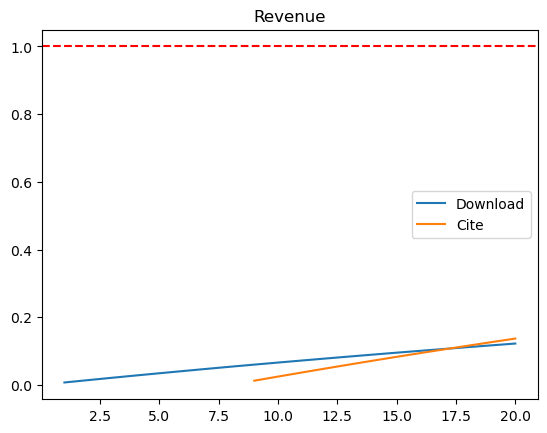

In [4]:
article = ArticleDAO(1, 'Publicater')
article.review(
  [IAuthor(address='Corresponding', sequence=0), IAuthor(address='Author1', sequence=1), IAuthor(address='Author2', sequence=2), IAuthor(address='Author3', sequence=3)],
  [IReview(address='Reviewer1', rating=4), IReview(address='Reviewer2', rating=5), IReview(address='Reviewer3', rating=3)]
)

article.emulate(20, 2)
# article.emulate(2154, 42)

# article.show()
# article.revenue(names=['download', 'cite'])
article.revenue_user()

In [18]:
article.holder()

,Publicater,Corresponding,Author1,Author2,Author3,Reviewer1,Reviewer2,Reviewer3,Cite,CiteSum,Download,DownloadSum
0,1000,307,461,153,76,333,416,250,None,None,None,None
1,1000,315,473,157,76,333,416,250,None,None,18,18
2,1000,323,485,161,76,333,416,250,None,None,18,36
3,1000,331,497,165,76,333,416,250,None,None,18,54
4,1000,339,509,169,76,333,416,250,None,None,18,72
...,...,...,...,...,...,...,...,...,...,...,...,...
496,1000,4275,6413,2137,76,333,416,250,None,None,18,8928
497,1000,4283,6425,2141,76,333,416,250,None,None,18,8946
498,1000,4291,6437,2145,76,333,416,250,None,None,18,8964
499,1000,4299,6449,2149,76,333,416,250,None,None,18,8982


In [5]:
article.finance()

,Publicater,Corresponding,Author1,Author2,Author3,Reviewer1,Reviewer2,Reviewer3,Cite,CiteSum,Download,DownloadSum
0,0.200321,0.122997,0.184696,0.061298,0.030449,0.133413,0.166667,0.100160,NaN,NaN,NaN,NaN
1,0.197006,0.124113,0.186367,0.061860,0.029945,0.131206,0.163909,0.098503,NaN,NaN,0.007092,0.007092
2,0.193798,0.125194,0.187984,0.062403,0.029457,0.129070,0.161240,0.096899,NaN,NaN,0.006977,0.013953
3,0.190694,0.126240,0.189550,0.062929,0.028986,0.127002,0.158658,0.095347,NaN,NaN,0.006865,0.020595
4,0.187688,0.127252,0.191066,0.063438,0.028529,0.125000,0.156156,0.093844,NaN,NaN,0.006757,0.027027
5,0.184775,0.128234,0.192535,0.063932,0.028086,0.123060,0.153732,0.092387,NaN,NaN,0.006652,0.033259
6,0.181951,0.129185,0.193959,0.064410,0.027656,0.121179,0.151383,0.090975,NaN,NaN,0.006550,0.039301
7,0.179211,0.130108,0.195341,0.064875,0.027240,0.119355,0.149104,0.089606,NaN,NaN,0.006452,0.045161
8,0.176554,0.131003,0.196681,0.065325,0.026836,0.117585,0.146893,0.088277,NaN,NaN,0.006356,0.050847
9,0.171468,0.130658,0.196159,0.065158,0.026063,0.114198,0.142661,0.085734,0.012346,0.012346,0.006173,0.055556


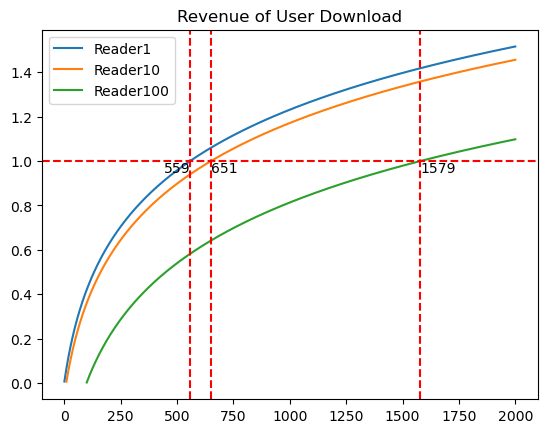

In [84]:
def revenue_user():
  df = pd.DataFrame()
  finance = article.get_finance()

  df['Reader1'] = finance['Download']
  none_values = [None] * 10
  none_values.extend(finance['Download'].iloc[10:])
  df['Reader10'] = none_values
  none_values = [None] * 100
  none_values.extend(finance['Download'].iloc[100:])
  df['Reader100'] = none_values

  df['Reader1'] = df['Reader1'].cumsum()
  df['Reader10'] = df['Reader10'].cumsum()
  df['Reader100'] = df['Reader100'].cumsum()
  ax = df.plot(title='Revenue of User Download')
  ax.axhline(y=1, color='r', linestyle='--')
  intersection_x = df.loc[df['Reader1'] >= 1].index.min()
  ax.text(intersection_x, 1, intersection_x, ha='right', va='top')
  ax.axvline(x=intersection_x, color='r', linestyle='--')
  intersection_x = df.loc[df['Reader10'] >= 1].index.min()
  ax.text(intersection_x, 1, intersection_x, ha='left', va='top')
  ax.axvline(x=intersection_x, color='r', linestyle='--')
  intersection_x = df.loc[df['Reader100'] >= 1].index.min()
  ax.text(intersection_x, 1, intersection_x, ha='left', va='top')
  ax.axvline(x=intersection_x, color='r', linestyle='--')
revenue_user()

In [71]:
import pandas as pd
import numpy as np

# 创建示例数据
data = {'column': np.arange(1, 21)}  # 原始数据列

df = pd.DataFrame(data)

# 在列前添加 10 个 None
none_values = [None] * 2
none_values.extend(df['column'].iloc[:18])
df['column2'] = none_values

# 输出结果
print(df)

    column  column2
0        1      NaN
1        2      NaN
2        3      1.0
3        4      2.0
4        5      3.0
5        6      4.0
6        7      5.0
7        8      6.0
8        9      7.0
9       10      8.0
10      11      9.0
11      12     10.0
12      13     11.0
13      14     12.0
14      15     13.0
15      16     14.0
16      17     15.0
17      18     16.0
18      19     17.0
19      20     18.0


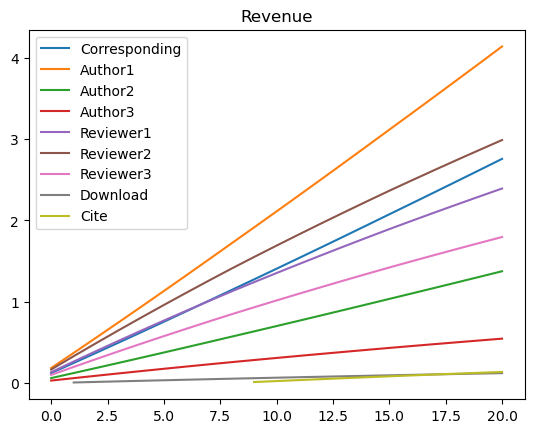

In [6]:
article.revenue(['Corresponding', 'Author1','Author2','Author3', 'Reviewer1', 'Reviewer2', 'Reviewer3', 'Download', 'Cite'])

# Proportion

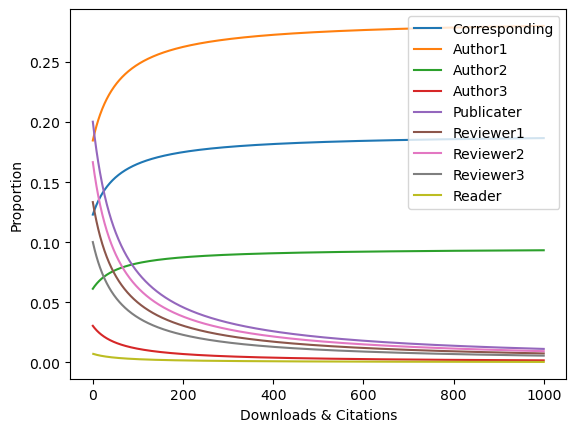

In [31]:
def proportion():
  log = article.get_log()
  df = pd.DataFrame()
  df['Corresponding'] = log['Corresponding']
  df['Author1'] = log['Author1']
  df['Author2'] = log['Author2']
  df['Author3'] = log['Author3']
  df['Publicater'] = log['Publicater']
  df['Reviewer1'] = log['Reviewer1']
  df['Reviewer2'] = log['Reviewer2']
  df['Reviewer3'] = log['Reviewer3']
  df['Reader'] = log['Download']
  ax = df.plot()
  ax.set_xlabel('Downloads & Citations')
  ax.set_ylabel('Proportion')
proportion()

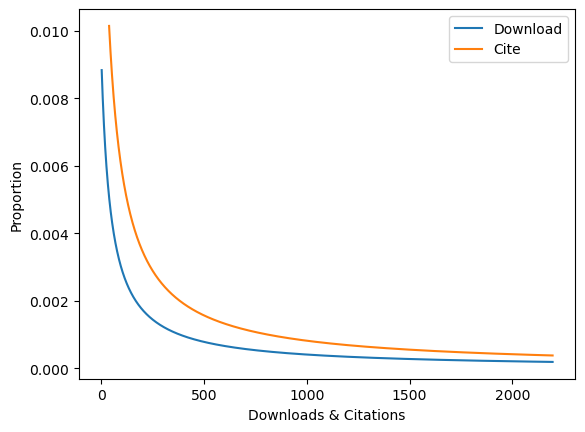

In [129]:
article.proportion(['Download', 'Cite'])

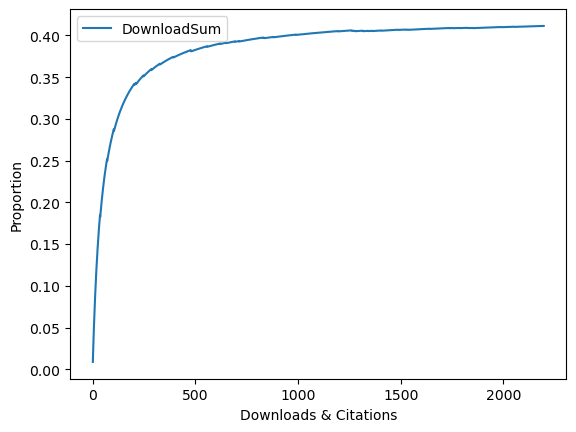

In [130]:
article.proportion(['DownloadSum'])

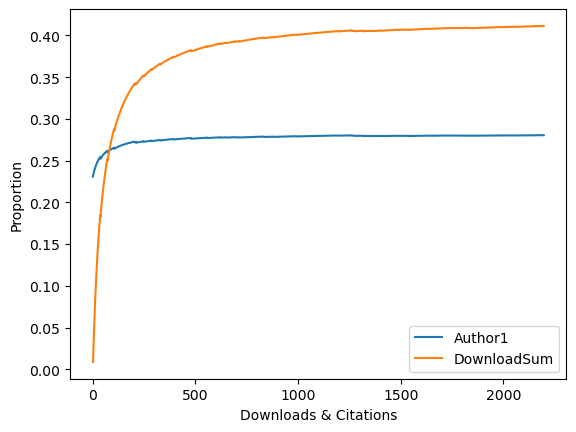

In [131]:
article.proportion(['Author1', 'DownloadSum'])

In [22]:
df = pd.DataFrame({
    'out': [20, 2154, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    'in': [1000, 2000, 1500, 3000, 2500, 1800, 2800, 2200, 1900, 2100, 2400, 2700]
})
names = ['in']

df2 = pd.DataFrame()
for name in names:
  df2[name] = df[name].cumsum()
df2

,in
0,1000
1,3000
2,4500
3,7500
4,10000
5,11800
6,14600
7,16800
8,18700
9,20800
